In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.io import imshow

from IPython.display import display
tf.__version__

'2.4.1'

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


In [4]:
train_images.dtype, train_images.shape

(dtype('uint8'), (60000, 28, 28))

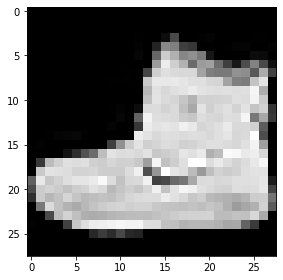

In [5]:
imshow(train_images[0])

In [6]:
def img_to_float(img):
  return (np.float32(img)[..., None]-127.5)/127.5
def img_to_uint8(img):
  return np.uint8(img*127.5+128).clip(0, 255)[...,0]

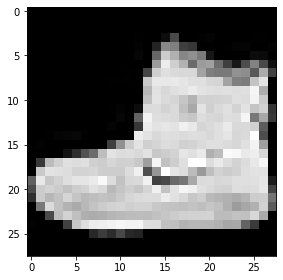

In [7]:
train_img_f32 = img_to_float(train_images)
imshow(img_to_uint8(train_img_f32[0]))

In [9]:
BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_img_f32).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
latent_dim = 100
generator = tf.keras.Sequential([
    Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((7, 7, 256)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
]
)

In [11]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
discriminator =  tf.keras.Sequential([
   Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28,28, 1)),
   LeakyReLU(),
   Dropout(0.3),
   Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
   LeakyReLU(),
   Dropout(0.3),
   Flatten(),
   Dense(1)]
)

In [12]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(generated_output):
    return loss_fn(tf.ones_like(generated_output), generated_output)

In [13]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = loss_fn(tf.ones_like(real_output), real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = loss_fn(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
EPOCHS = 50
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 latent_dim])

In [16]:
@tf.function
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random.normal([BATCH_SIZE, latent_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      return gen_loss, disc_loss

In [17]:
for epoch in range(15):
  start_time = time.time()
  for images in train_dataset:
      train_step(images)
  fake = generator(random_vector_for_generation, training=False)
  fake_concat = np.transpose(img_to_uint8(fake), [1,0,2]).reshape((28,-1))
  print(epoch, time.time()-start_time)
  display(PIL.Image.fromarray(fake_concat))
  
  

0 89.9477813243866


1 59.20023536682129


2 59.25111627578735


3 59.24855279922485


4 59.167911767959595


5 59.27145791053772


6 59.30877327919006


7 59.37397885322571


8 59.345611572265625


9 59.34937334060669


10 59.33029747009277


11 59.294721841812134


12 59.325294971466064


13 59.30851936340332


14 59.251888036727905
